/tmp/ipython-input-630346073.py:188: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device == "cuda")


Device: cuda
🚀 Training started


Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-630346073.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device == "cuda"):
Epoch 20/20: 100%|██████████| 469/469 [00:30<00:00, 15.30it/s, loss=0.0334]


✅ Training finished


Sampling: 100%|██████████| 250/250 [00:01<00:00, 212.84it/s]


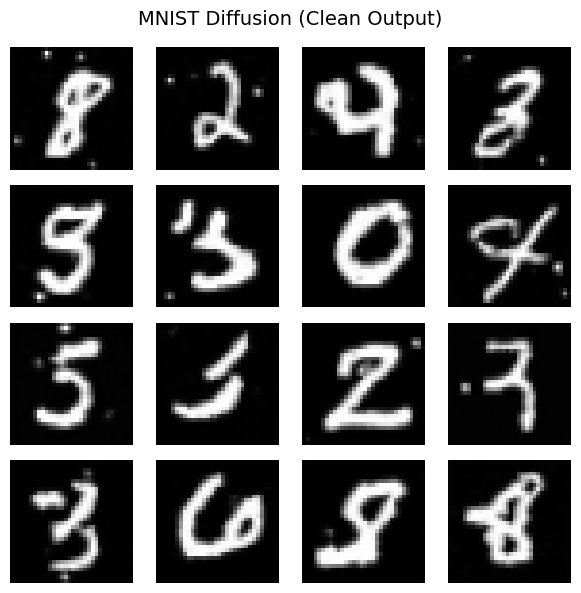

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math

class SinusoidalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([emb.sin(), emb.cos()], dim=-1)



class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm = nn.GroupNorm(8, out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t):
        h = F.silu(self.conv1(x))
        h = h + self.time_mlp(F.silu(t))[:, :, None, None]
        h = F.silu(self.norm(self.conv2(h)))
        return h + self.res(x)



class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = 64
        time_dim = base * 4

        self.time_mlp = nn.Sequential(
            SinusoidalEmbeddings(base),
            nn.Linear(base, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.d1 = ResidualBlock(1, base, time_dim)
        self.d2 = ResidualBlock(base, base * 2, time_dim)
        self.d3 = ResidualBlock(base * 2, base * 4, time_dim)

        self.ds1 = nn.Conv2d(base, base, 4, 2, 1)
        self.ds2 = nn.Conv2d(base * 2, base * 2, 4, 2, 1)

        self.us1 = nn.ConvTranspose2d(base * 4, base * 2, 4, 2, 1)
        self.us2 = nn.ConvTranspose2d(base * 2, base, 4, 2, 1)

        self.u1 = ResidualBlock(base * 4, base * 2, time_dim)
        self.u2 = ResidualBlock(base * 2, base, time_dim)

        self.final = nn.Conv2d(base, 1, 1)

    def forward(self, x, t):
        t = self.time_mlp(t)

        x1 = self.d1(x, t)
        x2 = self.d2(self.ds1(x1), t)
        x3 = self.d3(self.ds2(x2), t)

        x = self.u1(torch.cat([self.us1(x3), x2], dim=1), t)
        x = self.u2(torch.cat([self.us2(x), x1], dim=1), t)

        return self.final(x)



class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = (
                    self.decay * self.shadow[name]
                    + (1 - self.decay) * param.data
                )

    def apply(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data = self.shadow[name]



def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 1e-4, 0.02)


class Diffusion:
    def __init__(self, T, model, device):
        self.T = T
        self.model = model
        self.device = device

        self.beta = cosine_beta_schedule(T).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def q_sample(self, x0, t):
        noise = torch.randn_like(x0)
        a = self.alpha_bar[t][:, None, None, None]
        return torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise, noise

    @torch.no_grad()
    def ddim_sample(self, n=16, steps=250):
        x = torch.randn(n, 1, 32, 32, device=self.device)
        step = self.T // steps

        for i in tqdm(range(steps), desc="Sampling"):
            t = self.T - 1 - i * step
            t_tensor = torch.full((n,), t, device=self.device, dtype=torch.long)

            a = self.alpha_bar[t]
            a_prev = self.alpha_bar[t - step] if t - step >= 0 else torch.tensor(1.0, device=self.device)

            eps = self.model(x, t_tensor)
            x0 = (x - torch.sqrt(1 - a) * eps) / torch.sqrt(a)
            x0 = x0.clamp(-1, 1)

            x = torch.sqrt(a_prev) * x0 + torch.sqrt(1 - a_prev) * eps

        return x



def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    BATCH = 128
    EPOCHS = 20
    T = 500

    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH, shuffle=True, num_workers=2)

    model = UNet().to(device)
    diffusion = Diffusion(T, model, device)
    ema = EMA(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=device == "cuda")

    print("Training started")
    model.train()

    for epoch in range(EPOCHS):
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for x, _ in pbar:
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device)

            xt, noise = diffusion.q_sample(x, t)

            with torch.cuda.amp.autocast(enabled=device == "cuda"):
                pred = model(xt, t)
                loss = F.mse_loss(pred, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ema.update(model)
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    print(" Training finished")


    ema.apply(model)
    model.eval()

    samples = diffusion.ddim_sample(16, steps=250)

    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = samples[i, 0].cpu().clamp(-1, 1) * 0.5 + 0.5
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    plt.suptitle("MNIST Diffusion (Clean Output)", fontsize=14)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()